In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [22]:
df = pd.read_csv('/content/spam.csv', encoding='latin1')
df = df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'message'})
df['label'] = df['label'].map({'spam': 1, 'ham': 0})
df

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


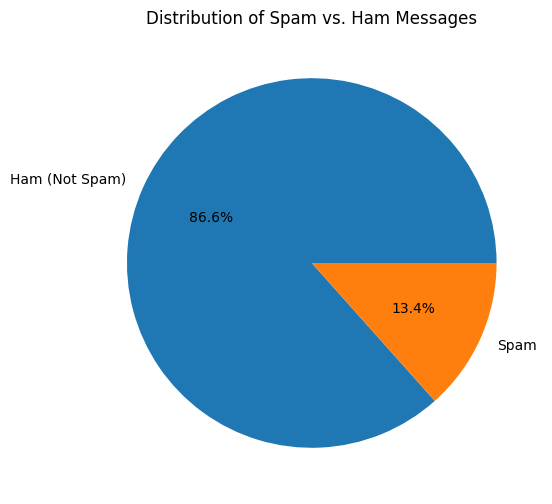

In [23]:
plt.figure(figsize=(6, 6))
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['Ham (Not Spam)', 'Spam'])
plt.title('Distribution of Spam vs. Ham Messages')
plt.ylabel('')
plt.show()

In [24]:
df['message_length'] = df['message'].apply(len)
df

,label,message,message_length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161
5568,0,Will Ì_ b going to esplanade fr home?,37
5569,0,"Pity, * was in mood for that. So...any other s...",57
5570,0,The guy did some bitching but I acted like i'd...,125


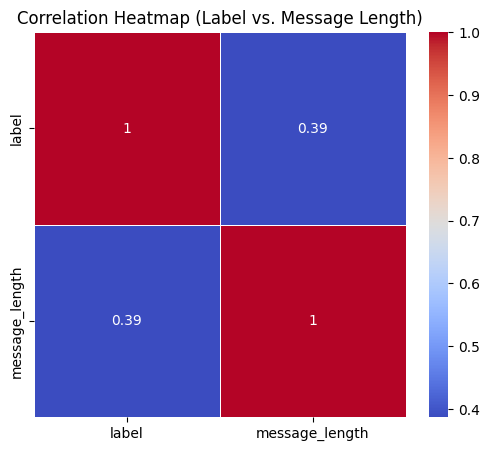

In [25]:

# Correlation Heatmap for numerical features
plt.figure(figsize=(6,5))
correlation_matrix = df[['label', 'message_length']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap (Label vs. Message Length)')
plt.show()

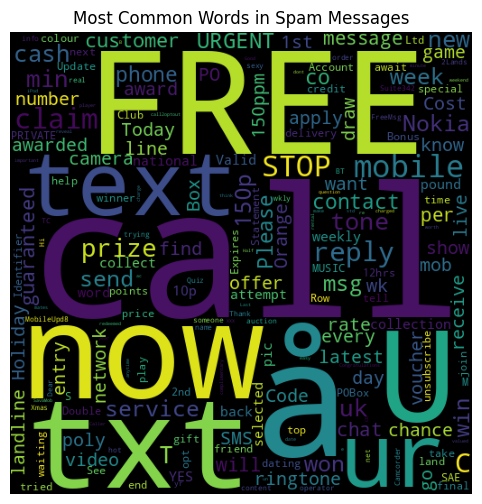

In [26]:
spam_words = ' '.join(list(df[df['label'] == 1]['message']))
spam_wc = WordCloud(width=512, height=512, collocations=False).generate(spam_words)
plt.figure(figsize=(8, 6))
plt.imshow(spam_wc)
plt.title("Most Common Words in Spam Messages")
plt.axis('off')
plt.show()

In [27]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['message'], df['label'], test_size=0.2, random_state=42
)


In [28]:
MAX_FEATURES = 2000
count_vectorizer = CountVectorizer(max_features=MAX_FEATURES)
X_train_count = count_vectorizer.fit_transform(X_train_text).toarray()
X_test_count = count_vectorizer.transform(X_test_text)

In [29]:
tfidf_vectorizer = TfidfVectorizer(max_features=MAX_FEATURES)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

In [30]:
class MyNaiveBayes:
    def __init__(self, alpha=1):
        self.alpha = alpha
        self.class_priors_ = None
        self.feature_log_prob_ = None
        self.classes_ = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        self.class_priors_ = np.zeros(n_classes)
        for i, c in enumerate(self.classes_):
            self.class_priors_[i] = np.sum(y == c) / n_samples

        self.feature_log_prob_ = np.zeros((n_classes, n_features))
        for i, c in enumerate(self.classes_):
            X_c = X[y == c]
            numerator = np.sum(X_c, axis=0) + self.alpha
            denominator = np.sum(X_c) + self.alpha * n_features
            self.feature_log_prob_[i, :] = np.log(numerator / denominator)

    def predict(self, X):
        y_pred = []
        for x in X.toarray():
            posteriors = []

            for i, c in enumerate(self.classes_):
                log_prior = np.log(self.class_priors_[i])
                log_likelihood = np.sum(x * self.feature_log_prob_[i, :])
                posterior = log_prior + log_likelihood
                posteriors.append(posterior)

            y_pred.append(self.classes_[np.argmax(posteriors)])
        return np.array(y_pred)



In [31]:
results_list = []

print("\nRunning Naive Bayes with CountVectorizer...")
nb_count = MyNaiveBayes()
nb_count.fit(X_train_count, y_train)
y_pred_nb_count = nb_count.predict(X_test_count)

results_list.append({
    'Model': 'Naive Bayes', 'Vectorizer': 'Count',
    'Accuracy': accuracy_score(y_test, y_pred_nb_count),
    'Precision': precision_score(y_test, y_pred_nb_count),
    'Recall': recall_score(y_test, y_pred_nb_count),
    'F1': f1_score(y_test, y_pred_nb_count)
})
print(results_list[-1])


Running Naive Bayes with CountVectorizer...
{'Model': 'Naive Bayes', 'Vectorizer': 'Count', 'Accuracy': 0.9829596412556054, 'Precision': 0.9781021897810219, 'Recall': 0.8933333333333333, 'F1': 0.9337979094076655}


In [32]:

print("Running Naive Bayes with TfidfVectorizer...")
nb_tfidf = MyNaiveBayes()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_nb_tfidf = nb_tfidf.predict(X_test_tfidf)

results_list.append({
    'Model': 'Naive Bayes', 'Vectorizer': 'TF-IDF',
    'Accuracy': accuracy_score(y_test, y_pred_nb_tfidf),
    'Precision': precision_score(y_test, y_pred_nb_tfidf),
    'Recall': recall_score(y_test, y_pred_nb_tfidf),
    'F1': f1_score(y_test, y_pred_nb_tfidf)
})
print(results_list[-1])

Running Naive Bayes with TfidfVectorizer...
{'Model': 'Naive Bayes', 'Vectorizer': 'TF-IDF', 'Accuracy': 0.9748878923766816, 'Precision': 1.0, 'Recall': 0.8133333333333334, 'F1': 0.8970588235294118}


In [33]:
results_df = pd.DataFrame(results_list)
results_df

,Model,Vectorizer,Accuracy,Precision,Recall,F1
0,Naive Bayes,Count,0.982960,0.978102,0.893333,0.933798
1,Naive Bayes,TF-IDF,0.974888,1.000000,0.813333,0.897059
